<a href="https://colab.research.google.com/github/gusmarlaj/Machine_Learning_Ideas/blob/master/WIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The WiDS Datathon 2024

The datasets (split into training and test sets) represents patients and their characteristics (age, race, BMI, zip code), their diagnosis and treatment information (breast cancer diagnosis code, metastatic cancer diagnosis code, metastatic cancer treatments, … etc.), their geo (zip-code level) demographic data (income, education, rent, race, poverty, …etc), as well as toxic air quality data (Ozone, PM25 and NO2) that tie health outcomes to environmental conditions. Each row in the data corresponds a single patient and her Diagnosis Period.

The task is to assess whether the **likelihood of the patient’s Diagnosis Period being less than 90 days** is *predictable* using these characteristics and information about the patient.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [ ]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

# Understanding the data

In [ ]:
# Check the number of rows and columns
print("Number of train samples are",train.shape)
print("Number of test samples are",test.shape)

Number of train samples are (12906, 83)
Number of test samples are (5792, 82)


In [ ]:
train.isnull().sum()

patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64

In [ ]:
train.isnull().sum()

patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64

In [ ]:
# Statistical Summary of categorical columns
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_id,int64,12906,12906,100.000000,0,0.000000,547381.196033,260404.959974,100063.000000,321517.000000,543522.000000,772671.750000,999896.000000
patient_zip3,int64,12906,739,5.726019,0,0.000000,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,999.000000
patient_age,int64,12906,67,0.519138,0,0.000000,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,91.000000
DiagPeriodL90D,int64,12906,2,0.015497,0,0.000000,0.624516,0.484266,0.000000,0.000000,1.000000,1.000000,1.000000
population,float64,12905,738,5.718271,1,0.007748,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,71374.131580
density,float64,12905,738,5.718271,1,0.007748,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,21172.000000
age_median,float64,12905,728,5.640787,1,0.007748,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,54.570000
age_under_10,float64,12905,718,5.563304,1,0.007748,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,17.675000
age_10_to_19,float64,12905,725,5.617542,1,0.007748,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,35.300000
age_20s,float64,12905,724,5.609794,1,0.007748,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,62.100000


# Statistical summary



Statistical Summary

Demographic Overview:

    The mean age of patients is 59.18 and there is almost equal percentage of male(50.10) and female patients(49.90). Majority of patients are married(47.68%)
    The average size of family is 3.20 with 51.85% having dual incomes

Economic Overview:

    Median household income is 74,374.37 dollars, and 32.55 % of households fall into the six-figure income bracket.
    Homeownership rate is 65.99% , and housing values vary, with a median of 339,817.16 dollars

Education:

    31.53% hold college education and 43.39% holds stem degree
    Labor force partcipation 61.62%

Environmental Factors:

    Health-related features include an average ozone level of 39.82, a 5.95% unemployment rate, and an 8.58% uninsured rate.
    Environmental indicators like PM25 and N02 levels are within expected ranges.

Community Characteristics:

    Community attributes encompass racial diversity, with 69.72% White, 11.45% Black, and 5.47% Asian. The Hispanic population constitutes 18.46%.
    Commute time averages 27.98 minutes, and 13.34% of the population reports having a disability.





In [ ]:

# Statistical Summary of categorical columns

train.describe(include=['object']).T.style.background_gradient()

,count,unique,top,freq
patient_race,6521,5,White,3588
payer_type,11103,3,COMMERCIAL,6032
patient_state,12855,50,CA,2438
patient_gender,12906,1,F,12906
breast_cancer_diagnosis_code,12906,50,1749,1982
breast_cancer_diagnosis_desc,12906,50,"Malignant neoplasm of breast (female), unspecified",1982
metastatic_cancer_diagnosis_code,12906,43,C773,7052
metastatic_first_novel_treatment,24,2,PEMBROLIZUMAB,13
metastatic_first_novel_treatment_type,24,1,Antineoplastics,24
Region,12854,4,South,3919


 Statistical Summary

*   There are 5 unique patient race with top White
*   Commercial payer_type has highest frequency
*   Patients are from 50 different states
*   Presence in 4 regions and 9 divisions with a notable frequency in South Region and East North Central Diviison
*   There are 50 unique codes in breast_cancer_diagnosis with top 1749,Malignant neoplasm of breast
*   metastatic cnacer diagnosis code has 43 unique values with C773 being prevalent
*   Limited data on novel treatments, mainly involving "PEMBROLIZUMAB.



In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 82 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             5792 non-null   int64  
 1   patient_race                           2891 non-null   object 
 2   payer_type                             5032 non-null   object 
 3   patient_state                          5771 non-null   object 
 4   patient_zip3                           5792 non-null   int64  
 5   patient_age                            5792 non-null   int64  
 6   patient_gender                         5792 non-null   object 
 7   bmi                                    1777 non-null   float64
 8   breast_cancer_diagnosis_code           5792 non-null   object 
 9   breast_cancer_diagnosis_desc           5792 non-null   object 
 10  metastatic_cancer_diagnosis_code       5792 non-null   object 
 11  meta

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

About Data:

There are 12906 rows 83 columns are there. Few columns has considerable amount of missing data. Columns with more missing data are patient_race, payer_type, bmi, metastatic_first_novel_treatment and metastatic_first_novel_treatment_type Columns like Ozone, PM25, N02 represent environmental indicators Tareget variable: DiagPeriodL90D


In [ ]:
#Loos at categorical and numerical variables

categorical_features = train.select_dtypes('object').columns
# visualize_features = ['State_Factor', 'building_class', 'facility_type', 'Year_Factor']
numerical_features= train.select_dtypes('number').columns

categorical_features

Index(['patient_race', 'payer_type', 'patient_state', 'patient_gender',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division'],
      dtype='object')

In [ ]:
numerical_features

Index(['patient_id', 'patient_zip3', 'patient_age', 'bmi', 'population',
       'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',
       'male', 'female', 'married', 'divorced', 'never_married', 'widowed',
       'family_size', 'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_ownership', 'housing_units',
       'home_value', 'rent_median', 'rent_burden', 'education_less_highschool',
       'education_highschool', 'education_some_college', 'education_bachelors',
     

# Data pre-processing


**Duplicate Values**

In [ ]:
print('Number of duplicate values in train are :',train.duplicated().sum())

Number of duplicate values in train are : 0


** Dropping Duplicate Records**

Duplicates can be removed using pandas with the DataFrame.drop_duplicates() method. This method identifies and eliminates duplicate rows, keeping only the first occurrence of each unique record. Since for this dataset we found no duplicate records, the we don't use the drop_duplicates() method

E.g train.drop_duplicates(inplace=True)

**Identifying missing values**

Here we have a method check_missing_values() to analyze missing values in a pandas DataFrame.

In [ ]:
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df





This summarized data is then sorted in descending order to get a clear overview of which columns have the most significant number of missing entries.


In [ ]:
df = check_missing_values(train)
print(df.sort_values(by='Missing Values', ascending=False))

                                       Missing Values  Percentage
metastatic_first_novel_treatment                12882   99.814040
metastatic_first_novel_treatment_type           12882   99.814040
bmi                                              8965   69.463815
patient_race                                     6385   49.473113
payer_type                                       1803   13.970246
...                                               ...         ...
age_10_to_19                                        1    0.007748
education_less_highschool                           1    0.007748
education_highschool                                1    0.007748
education_some_college                              1    0.007748
housing_units                                       1    0.007748

[75 rows x 2 columns]


## **Handling Missing Data**

Handling missing values is an essential step in the data preprocessing journey. In this section, we will explore various techniques to effectively impute missing values, with a focus on both numerical and categorical features.

    Why Impute?

Imputation becomes a practical solution when dealing with columns that contain relatively few missing values. It helps maintain the completeness of the dataset, ensuring that valuable information is not lost.

    How to choose the suitable methods for different type of feature?

    For numerical features:
        SimpleImputer : This imputer is configured to use the median as the imputation strategy. While we showcase the median here, the SimpleImputer allows you to choose from various strategies such as mean, constant, or even custom values.
        Alternative Methods: Other imputation methods such as IterativeImputer and KNNImputer can be explored. These methods offer flexibility based on the nature of your dataset.
    For categorical features:
        Categorical features present a unique challenge when it comes to imputation. In this tutorial, we'll tackle missing values in categorical columns by filling them with the label 'unknown'. This approach not only preserves the integrity of the data but also allows for a seamless handling of missing categorical information.
        Other methods:https://medium.com/analytics-vidhya/handle-missing-values-in-categorical-features-b7c5b073dda2


**Solution 1:**Dropping all the records having mising values.

**Solution 2:**Dropping columns having percentage of missing values above a threshold

**Solution 3:** K-nearest neighbors, regression imputation

**Solution 1**: Dropping all the records having mising values

In [ ]:
print("No. of records before dropping missing values : ",train.shape[0])
df_dropall_missing_values = train.dropna()
print("No. of records after dropping missing values : ",df_dropall_missing_values.shape[0])

No. of records before dropping missing values :  12906
No. of records after dropping missing values :  3


**Solution 2**: Dropping columns having percentage of missing values abobe a threshold

We try with dropping columns having a 30% (threshold can be adjusted) missing data. The modified dataframe is later stored in a new one (df_train_dropped_columns)


In [ ]:
df_train_dropped_columns = train.drop(columns=train.columns[train.isnull().mean() > 0.3])

print("No. of columns before dropping: ", train.shape[1] )
print("No. of columns after dropping: ", df_train_dropped_columns.shape[1] )
print(train.shape[1]- df_train_dropped_columns.shape[1]," columns dropped")

# Identify which columns were dropped
dropped_columns = train.columns.difference(df_train_dropped_columns.columns)
print(dropped_columns)

No. of columns before dropping:  83
No. of columns after dropping:  79
4  columns dropped
Index(['bmi', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'patient_race'],
      dtype='object')


We notice that there are still some missing data from some columns but significantly lesser than before. Let us check by dropping all the records with missing values now. The mofidfied dataframe is stored in df_dropped_missing_values.

In [ ]:
check_missing_values(df_train_dropped_columns)

,Missing Values,Percentage
payer_type,1803,13.970246
patient_state,51,0.395165
Region,52,0.402913
Division,52,0.402913
population,1,0.007748
...,...,...
health_uninsured,1,0.007748
veteran,1,0.007748
Ozone,29,0.224702
PM25,29,0.224702


In [ ]:
df_dropped_missing_values = df_train_dropped_columns.dropna()

print("No. of records before dropping missing values : ",df_train_dropped_columns.shape[0])
print("No. of records after dropping missing values : ",df_dropped_missing_values.shape[0])

No. of records before dropping missing values :  12906
No. of records after dropping missing values :  11043


We observe that, we have sufficient number of records in the train set unlike in Solution 1. The modified train set df_dropped_missing_values has no missing values and thus, we copy in into the original train set df_train

In [ ]:
train = df_dropped_missing_values.copy()



Since we performed some preprocessing on the train set, the same has to be done on the test set as well.


In [ ]:
# Drop the same columns from test set
test = test.drop(columns=dropped_columns)
#Drop rest of the missing values in test set
test.dropna(inplace=True)
#Check the shapes of train and test set
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (11043, 79)
Test set shape:  (4999, 78)


Notice that there are still some missing data from some columns but significantly lesser than before. The test set was reduced from 5792 rows into 5001 which is a problem in this challenge because we need to keep the original number of rows (5792)

**Solution 3**

In [ ]:
from sklearn.impute import SimpleImputer

# Identify columns with missing values
missing_columns = [col for col in train.columns if train[col].isnull().any()]

# Count the number of missing values per column
missingvalues_count = train.isna().sum()

# Create a DataFrame with columns and their corresponding missing values count (excluding columns with no missing values)
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]

# Identify categorical and numerical features
categorical_features = train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes('number')

# Define a function to find the intersection of two lists
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

# Find missing columns that are categorical or numerical
cat_miss = intersection(missing_columns, categorical_features)
num_miss = intersection(missing_columns, numerical_features)

# Impute missing values in categorical features
if len(cat_miss) > 0:
    cat_imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="unknown")
    train[cat_miss] = cat_imputer.fit_transform(train[cat_miss])
    test[cat_miss] = cat_imputer.fit_transform(test[cat_miss])

# Use Simple Imputer for numerical features (using median as an example)
num_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
train[num_miss] = num_imputer.fit_transform(train[num_miss])
test[num_miss] = num_imputer.fit_transform(test[num_miss])

# Uncomment the following lines to use KNN imputer
# from sklearn.impute import KNNImputer
# knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

In [ ]:
print(train.isnull().sum())

patient_id        0
patient_race      0
payer_type        0
patient_state     0
patient_zip3      0
                 ..
veteran           0
Ozone             0
PM25              0
N02               0
DiagPeriodL90D    0
Length: 83, dtype: int64


# Plotting

Plotting the categorical features for the training and test set to find distribution mismatch


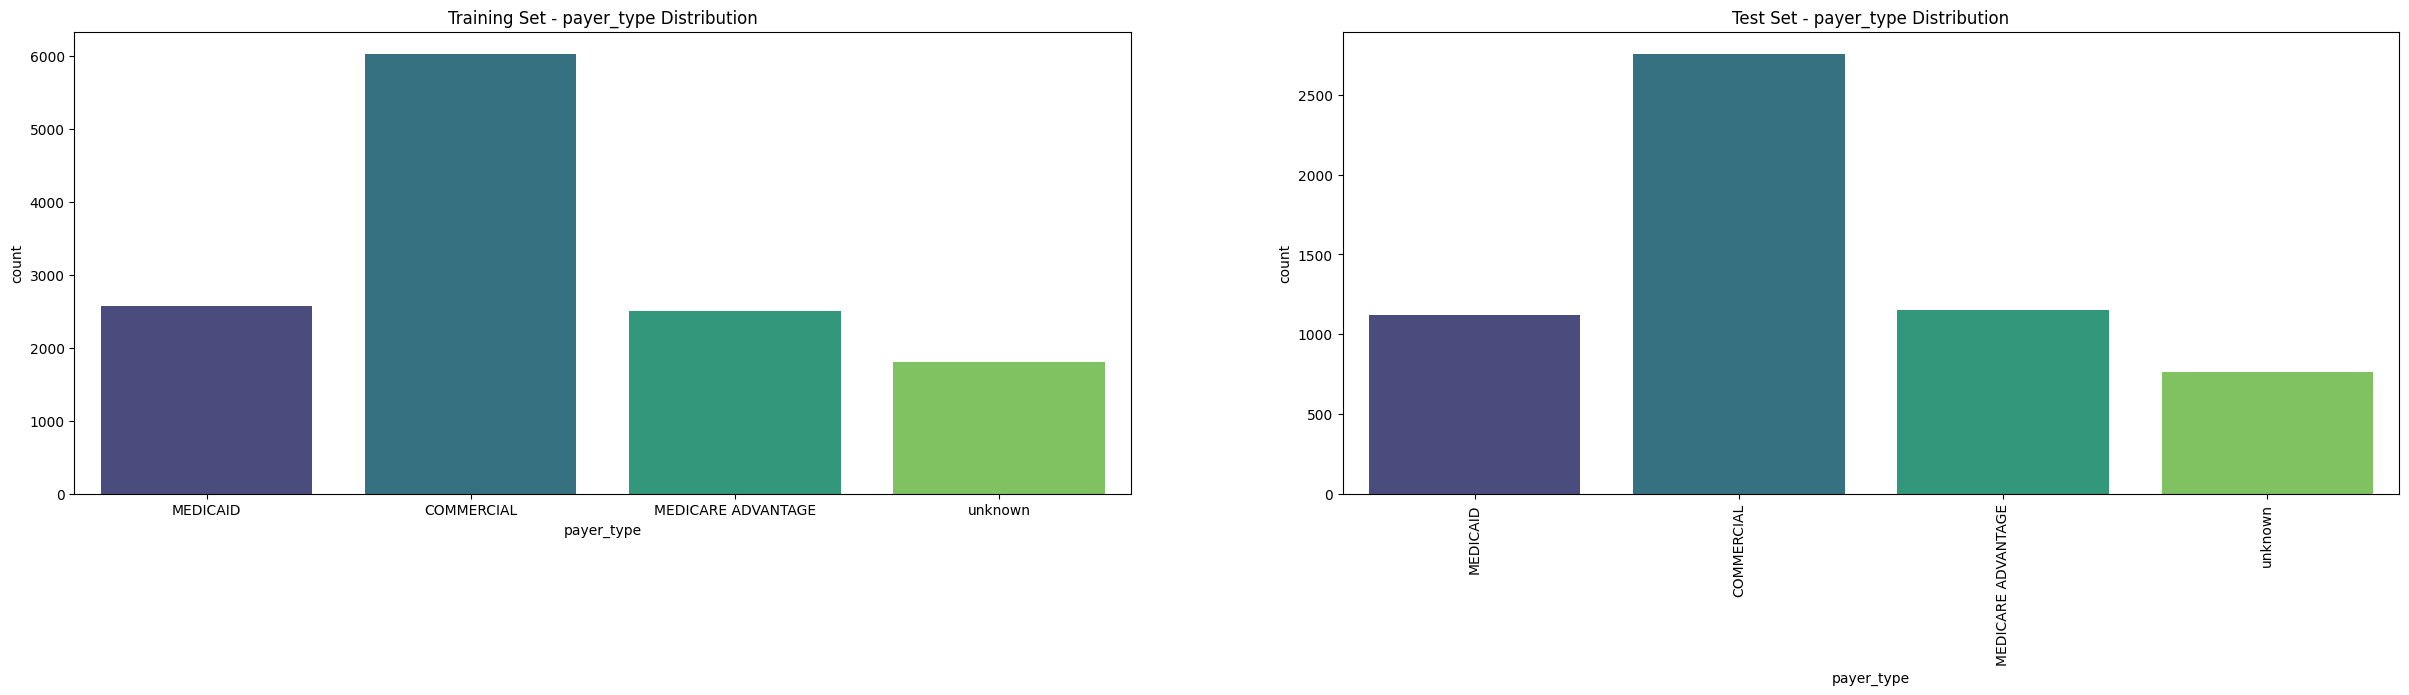

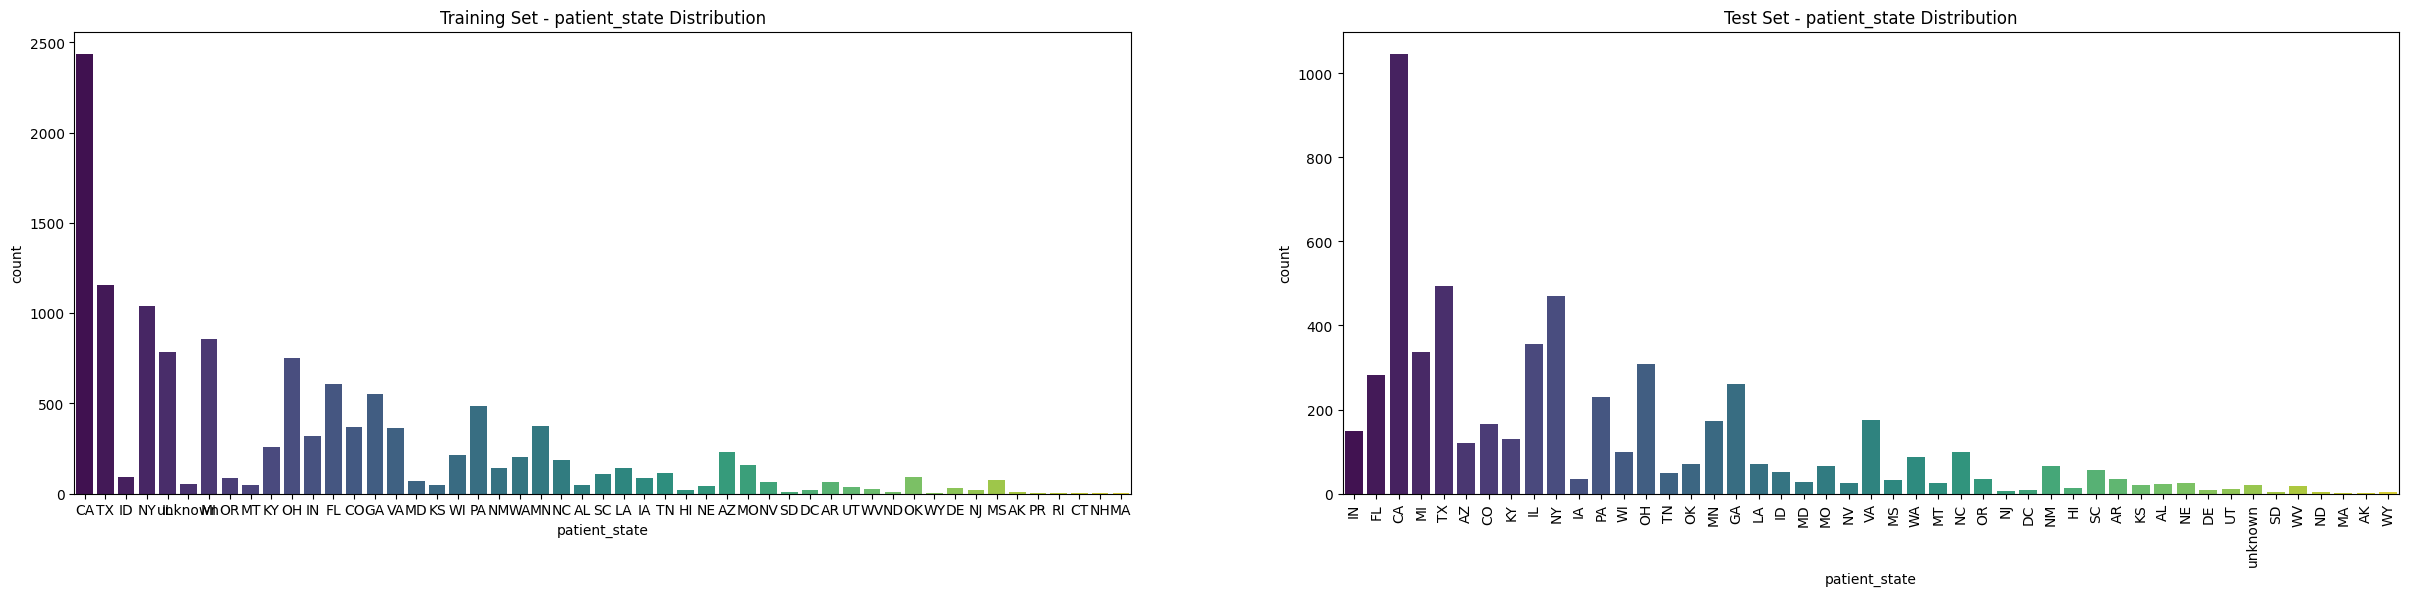

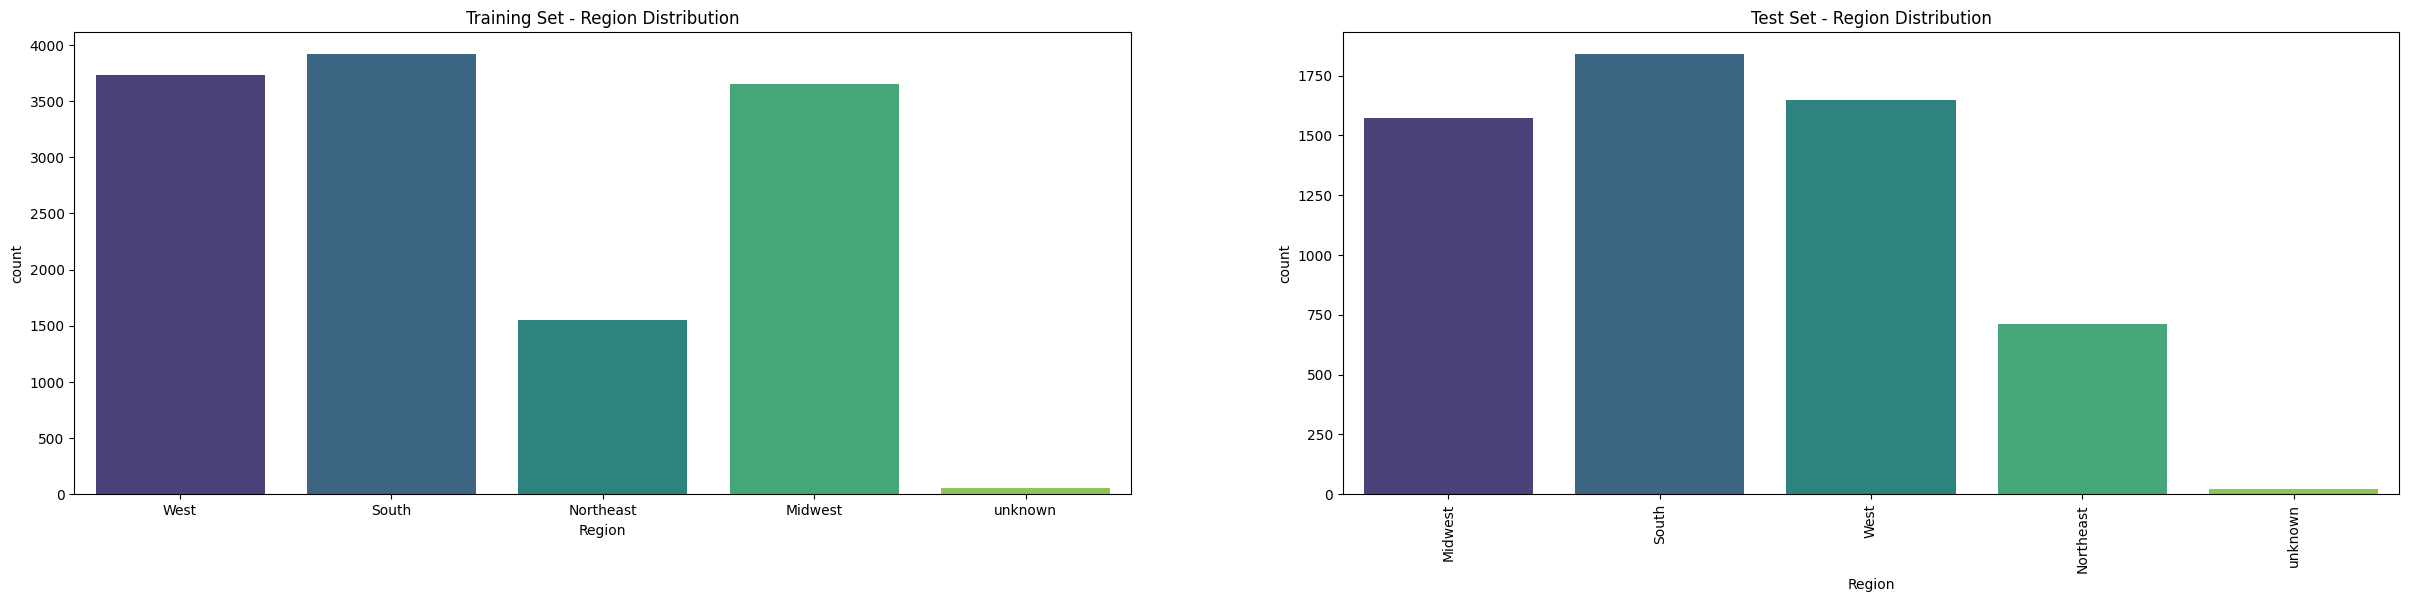

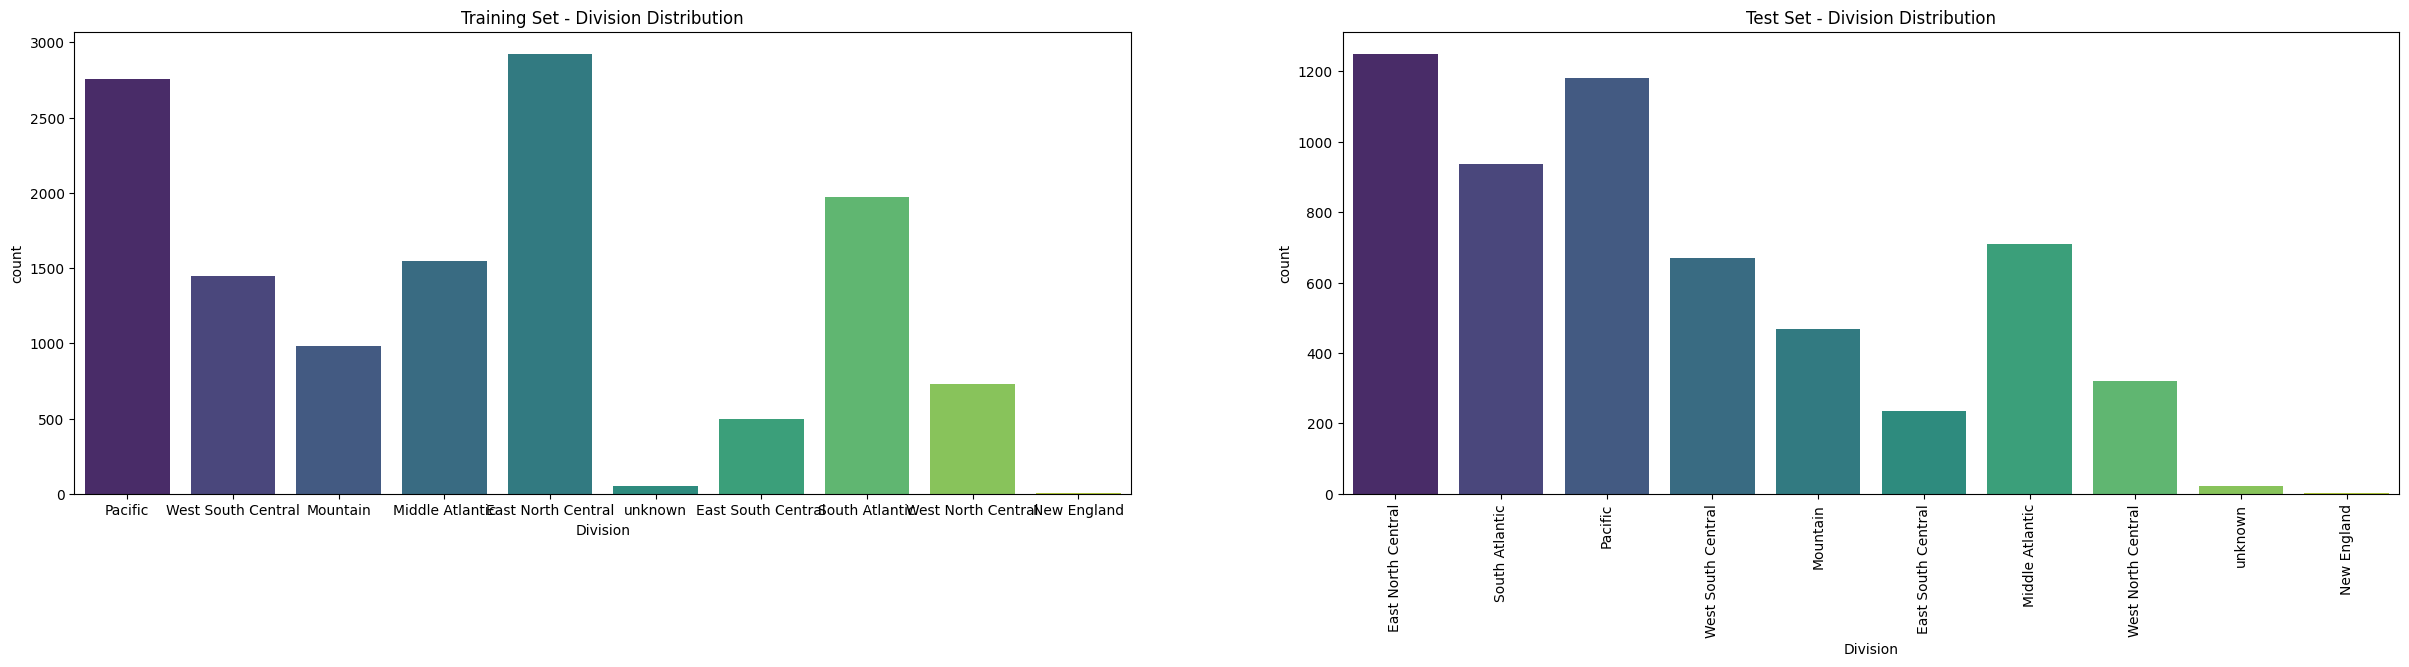

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_distribution(train, test, categorical_features):
    for feature in categorical_features:
        plt.figure(figsize=(30, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(data=train, x=feature, palette='viridis')
        plt.title(f'Training Set - {feature} Distribution')

        plt.subplot(1, 2, 2)
        sns.countplot(data=test, x=feature, palette='viridis')
        plt.title(f'Test Set - {feature} Distribution')

        # Set rotation for x-axis labels
        for label in plt.gca().get_xticklabels():
            label.set_rotation(90)

        plt.show()

# List of categorical features
categorical_features_to_check = ['payer_type', 'patient_state', 'Region', 'Division']

# Plot the distribution
plot_categorical_distribution(train, test, categorical_features_to_check)


## **Check for Imbalanced Classes¶**

Class imbalance can significantly impact the performance of machine learning models, leading to biased predictions favoring the majority class. Hence, it is important to identify and address this to ensure accurate and fair model outcomes.

No. of instances per class
1    8060
0    4846
Name: DiagPeriodL90D, dtype: int64


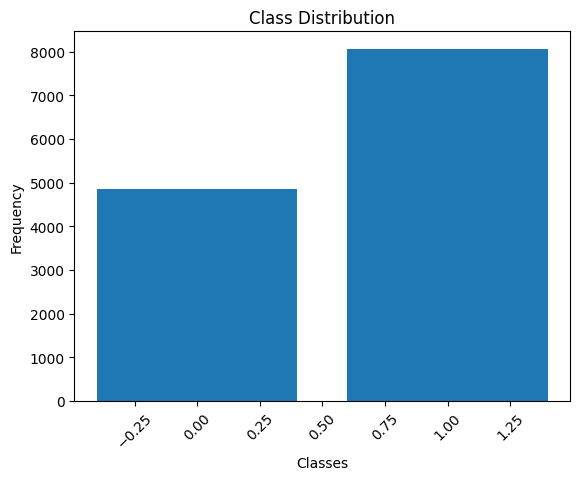

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def check_class_distribution(df):

    # Count the number of classes
    class_counts = df["DiagPeriodL90D"].value_counts()

    # Display the number of instances per class
    print("No. of instances per class")
    print(class_counts)

    # Plotting the bar graph for class distribution
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()


check_class_distribution(train)


## **Handling Class Imbalance**

Here class 1 is the majority class and class 0 is the minority class. Whether the data is imbalanced depends on your specific dataset. One naive approach to balance a dataset is by randomly undersampling the majority class. This involves randomly removing some instances from the majority class to match the number of instances in the minority class.


No. of instances per class
1    4846
0    4846
Name: DiagPeriodL90D, dtype: int64


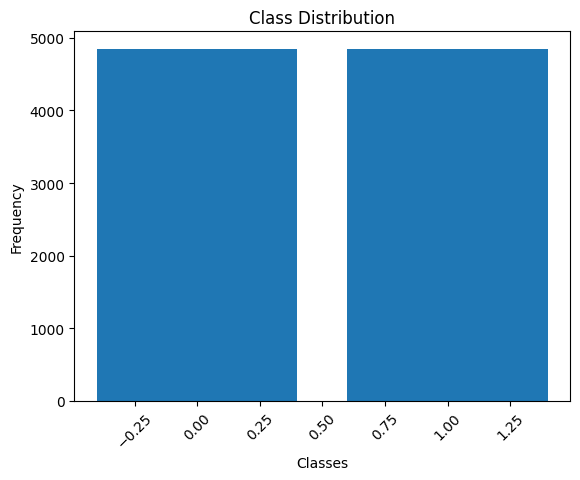

In [ ]:
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = train[train['DiagPeriodL90D'] == 1]
minority_class = train[train['DiagPeriodL90D'] == 0]

# Randomly undersample the majority class to match the minority class size
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_df = pd.concat([majority_downsampled, minority_class])

# Shuffle the rows in the balanced DataFrame to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42)

train = balanced_df.copy()
check_class_distribution(train)



## **Encoding Categorical variables**

Categorical variables contain non-numeric data and need to be converted to numerical format for machine learning algorithms to process them.

We use LabelEncoder for encoding categorical labels into numerical values. It works by assigning a unique integer to each unique category in the categorical variable.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

# Model Training

**Model 1:** *Using Logistic Regression*                              

**Model 2:** *CatBoostClassifier*

## **Model 1**

Separate train data into training features and target

In [ ]:
X = train.drop('DiagPeriodL90D', axis=1)
y = train['DiagPeriodL90D']



Splitting the train set


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



Fitting the model


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the classifier
log_reg = LogisticRegression(max_iter=1000, solver='sag')

# Train the classifier
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='sag')

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.51708575 0.50741457 0.51515152 0.52193548 0.52709677]
Mean cross-validation score: 0.5177368191177388


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = log_reg.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.5064466219700877
Precision: 0.48732394366197185
Recall: 0.5580645161290323
F1 Score: 0.5203007518796993
Confusion Matrix:
 [[463 546]
 [411 519]]


Evaluate how well the model learnt

# **Submission 1**

 prediction in our test set test

In [ ]:
predictions = log_reg.predict_proba(test)
predictions = predictions[:,1]

In [ ]:
submission_df_1 = pd.DataFrame({
    'patient_id': test['patient_id'],
    'DiagPeriodL90D': predictions
})
submission_df1.head()

,patient_id,DiagPeriodL90D
0,573710,0.493502
1,593679,0.508162
2,184532,0.500084
3,447383,0.494877
5,281312,0.490088


In [ ]:
submission_df1.to_csv('submission3_1.csv')

## **Model 2**

-Building the model.

-Split into traiing and testing

Pooling

In [ ]:
#Install the package
pip install catboost

import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

SyntaxError: invalid syntax (<ipython-input-257-9e8966c11347>, line 2)

In [ ]:
train_pool = Pool(X_train,y_train)
val_pool= Pool(X_val,y_val)
test_pool = Pool(test)

CatBoost classifier (CatBoostClassifier) using the training data (train_pool) and evaluates it on the validation data (val_pool). Then, it calculates the F1 score based on the predictions made on the validation set

In [ ]:
cat_1 = CatBoostClassifier(verbose=200,learning_rate = 0.2)
cat_1.fit(train_pool, eval_set=val_pool)
y_pred_catboost_1 = cat_1.predict(val_pool)

f1_score_catboost_1 = f1_score(y_val, y_pred_catboost_1)
print(f'F1 Score (CatBoost): {f1_score_catboost_1}')



0:	learn: 0.6091193	test: 0.6159167	best: 0.6159167 (0)	total: 68.7ms	remaining: 1m 8s
200:	learn: 0.2753838	test: 0.5675930	best: 0.5219384 (19)	total: 4.72s	remaining: 18.8s
400:	learn: 0.1655817	test: 0.6183237	best: 0.5219384 (19)	total: 9.11s	remaining: 13.6s
600:	learn: 0.1032795	test: 0.6667129	best: 0.5219384 (19)	total: 14.8s	remaining: 9.8s
800:	learn: 0.0688913	test: 0.7113662	best: 0.5219384 (19)	total: 19s	remaining: 4.73s
999:	learn: 0.0485487	test: 0.7557517	best: 0.5219384 (19)	total: 23.3s	remaining: 0us

bestTest = 0.521938433
bestIteration = 19

Shrink model to first 20 iterations.
F1 Score (CatBoost): 0.7779237844940867


The provided code is similar to the previous one, but it uses different hyperparameters for training the CatBoost classifier (cat_2)

In [ ]:
cat_2 = CatBoostClassifier(iterations=2000, verbose=200, learning_rate = 0.06)
cat_2.fit(train_pool, eval_set=val_pool)
y_pred_catboost_2 = cat_2.predict(val_pool)

f1_score_catboost_2 = f1_score(y_val, y_pred_catboost_2)
print(f'F1 Score (CatBoost): {f1_score_catboost_2}')

0:	learn: 0.6649034	test: 0.6669226	best: 0.6669226 (0)	total: 34.3ms	remaining: 1m 8s
200:	learn: 0.4154952	test: 0.5255252	best: 0.5209942 (70)	total: 4.48s	remaining: 40.1s
400:	learn: 0.3445005	test: 0.5363705	best: 0.5209942 (70)	total: 10.4s	remaining: 41.5s
600:	learn: 0.2889668	test: 0.5518816	best: 0.5209942 (70)	total: 15.7s	remaining: 36.6s
800:	learn: 0.2454181	test: 0.5655889	best: 0.5209942 (70)	total: 21.6s	remaining: 32.3s
1000:	learn: 0.2104702	test: 0.5793301	best: 0.5209942 (70)	total: 25.9s	remaining: 25.8s
1200:	learn: 0.1812503	test: 0.5914933	best: 0.5209942 (70)	total: 30.3s	remaining: 20.2s
1400:	learn: 0.1571144	test: 0.6033431	best: 0.5209942 (70)	total: 35.8s	remaining: 15.3s
1600:	learn: 0.1377127	test: 0.6173684	best: 0.5209942 (70)	total: 40.1s	remaining: 9.98s
1800:	learn: 0.1217756	test: 0.6304443	best: 0.5209942 (70)	total: 45.1s	remaining: 4.98s
1999:	learn: 0.1072170	test: 0.6442032	best: 0.5209942 (70)	total: 53s	remaining: 0us

bestTest = 0.5209941

By changing the hyperparameters such as the **number of iterations** and the **learning rate**, you can explore different configurations to find the one that yields the best performance on your validation set. This process is essential for **hyperparameter tuning** and *improving the model's performance.*

In [ ]:
# Import libraries
from sklearn.linear_model import LinearRegression
from scipy.special import expit as sigmoid  # Logistic function

Linear *regression*: using a linear regression model and then transforming its predictions into a probability scale between 0 and 1 using a sigmoid function (sigmoid(predictions)). This transformation can be useful if you want to interpret the predictions as probabilities, especially if you're dealing with a binary classification problem.

Here by combining predictions from multiple models, you can potentially leverage the strengths of each model and create a more robust or accurate prediction.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting
predictions = model.predict(test)

# Transforming predictions to [0, 1] scale
linear_pred = sigmoid(predictions)

# prob_predictions can be interpreted as probabilities
print(linear_pred)

[0.64772996 0.65351251 0.65793027 ... 0.6621867  0.55175993 0.56280279]


Ensamble

In [ ]:
y_pred_1 = cat_1.predict_proba(test_pool)[:, 1]
y_pred_2 = cat_2.predict_proba(test_pool)[:, 1]
prediction = 0.4 * y_pred_1 + 0.4 * y_pred_2 + 0.2 *linear_pred
prediction

array([0.73735938, 0.64044244, 0.69152727, ..., 0.84061007, 0.15899624,
       0.64880928])

## **Submission 2**

In [ ]:
submission_df_2 = pd.DataFrame({'patient_id':test['patient_id'], 'DiagPeriodL90D': prediction})
submission_df_2.head()

,patient_id,DiagPeriodL90D
0,573710,0.737359
1,593679,0.640442
2,184532,0.691527
3,447383,0.726641
5,281312,0.150424


In [ ]:
submission_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 5791
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      4999 non-null   int64  
 1   DiagPeriodL90D  4999 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 117.2 KB


In [ ]:
# prompt: keep 5792 rows instead of 5001

submission_df_2 = submission_df_2.iloc[:5792]


In [ ]:
submission_df_2.to_csv('submission3.csv')

## **Model 3**

**List of Kaggle Notebooks Used as a Reference**

WIDS_MAAS_2024_Tutorial_Day_1 --> Afsana

BASELINE XGB BASIC EDA 📶and FEATURE IMPORTANCES🧠 --> ANOPSY



